# Problem Definition
Credit card fraud detection involves identifying fraudulent transactions from genuine ones. The main goal is to accurately classify each transaction as either fraudulent or non-fraudulent, aiming to reduce false positives and false negatives. We’ll use a dataset from Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud.

# Data Collection

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('creditcard.csv')


# Data Cleaning and Preprocessing

In [ ]:
# Check for missing values
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        1
V4        1
V5        1
V6        1
V7        1
V8        1
V9        1
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64


In [ ]:
#Handling missing values
df.dropna(inplace=True)

In [ ]:
# View basic statistics
print(df.describe())

               Time           V1           V2           V3           V4  \
count   9964.000000  9964.000000  9964.000000  9964.000000  9964.000000   
mean    5933.588719    -0.241530     0.280348     0.906359     0.260247   
std     4448.730907     1.522697     1.308496     1.156948     1.440500   
min        0.000000   -27.670569   -34.607649   -15.496222    -4.657545   
25%     2061.000000    -1.011783    -0.208614     0.412198    -0.615591   
50%     4546.000000    -0.372609     0.286168     0.943149     0.218492   
75%    10162.250000     1.151550     0.900736     1.601871     1.119367   
max    14861.000000     1.960497     8.636214     4.101716    10.463020   

                V5           V6           V7           V8           V9  ...  \
count  9964.000000  9964.000000  9964.000000  9964.000000  9964.000000  ...   
mean     -0.046342     0.132335    -0.071847    -0.065317     0.801220  ...   
std       1.183634     1.307586     1.077872     1.260140     1.156424  ...   
min     

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Exploratory Data Analysis (EDA)

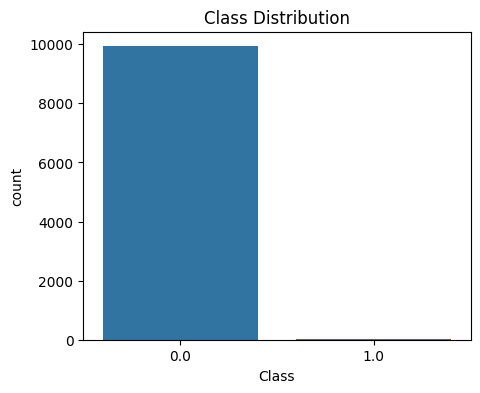

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the class distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()


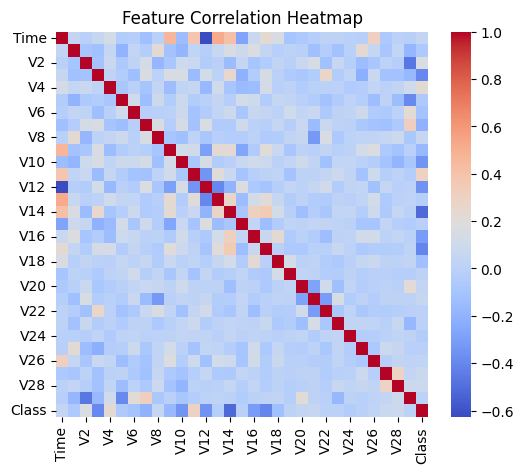

In [ ]:
# Correlation heatmap
corr = df.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Feature Engineering

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


# Model Selection and Training

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Instantiate models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

In [ ]:
# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    print(f"{model_name} - Training complete")

Logistic Regression - Training complete
Random Forest - Training complete
XGBoost - Training complete


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
results={}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    # Calculate evaluation metrics
    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        #'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

# Convert results to a DataFrame for easy viewing and comparison
results_df = pd.DataFrame(results).transpose()
results_df

,accuracy,recall,f1
Logistic Regression,0.997993,0.625,0.714286
Random Forest,0.999498,0.875,0.933333
XGBoost,0.998495,0.750,0.800000


In [ ]:
max=0
for model_name,metrics in results.items():
  if metrics['accuracy']>max:
    max=metrics['accuracy']
    best_model=model_name
print("Best Model:",best_model)

Best Model: Random Forest


# Cross validation on best model

In [ ]:
from sklearn.model_selection import cross_val_score
# Select the best model based on F1 score
best_model_name = results_df['f1'].idxmax()
best_model = models[best_model_name]

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')
print(f"{best_model_name} Cross-validated F1 score:", cv_scores.mean())

Random Forest Cross-validated F1 score: 0.8949999999999999


# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

# Randomized search on Random Forest
rf_model = RandomForestClassifier()
random_search = RandomizedSearchCV(rf_model, param_grid, n_iter=10, cv=3, scoring='f1', random_state=42)
random_search.fit(X_train_bal, y_train_bal)

# Best model
best_rf = random_search.best_estimator_
print("Best Random Forest parameters:", random_search.best_params_)


Best Random Forest parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 15}


# Model Evaluation

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1985
         1.0       1.00      0.75      0.86         8

    accuracy                           1.00      1993
   macro avg       1.00      0.88      0.93      1993
weighted avg       1.00      1.00      1.00      1993



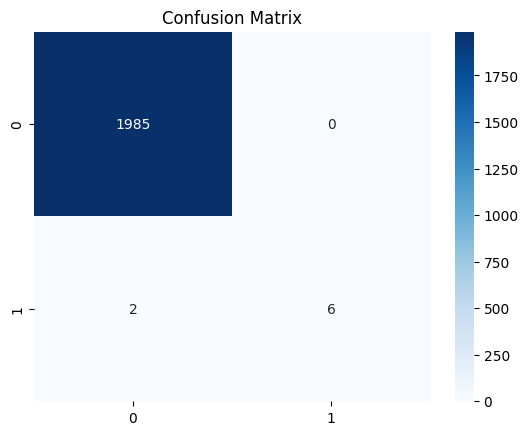

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the best model
y_pred = best_rf.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

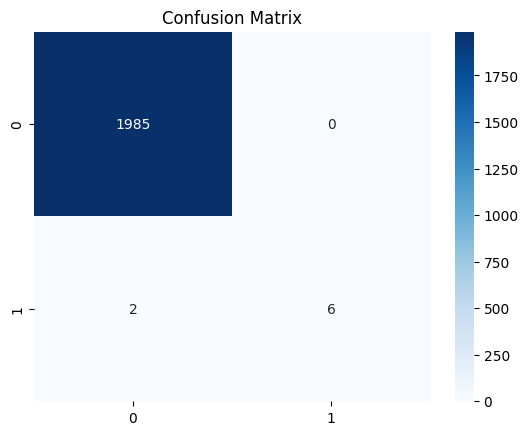

In [ ]:
#Confusion Matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# Save the Model

In [ ]:
import joblib

# Save the best model
joblib.dump(best_rf, 'best_rf_model.pkl')
print("Model saved as 'best_churn_model.pkl'")


Model saved as 'best_churn_model.pkl'
